Source des données: https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import datetime as dt
# %matplotlib notebook
# !wget https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7
#! mv 63352e38-d353-4b54-bfd1-f1b3ee1cabd7 data_01_11.csv

# Personne à l'hopital v.s. dc

In [3]:
#df = pd.read_csv('data_01_11.csv', sep=';')
df = pd.read_csv('datas/donnees-hospitalieres-covid19-2021-01-10-19h03.csv', sep=';')
days = np.unique(df['jour'].values)
days_dt = np.array([dt.datetime.fromisoformat(day) for day in days])
datas_per_day = []
for day in days:
    datas_per_day.append(df[np.logical_and(df['jour']==day, df['sexe']==0)])


In [4]:
dc =  np.array([sum(x['dc'].values) for x in datas_per_day])
rea = np.array([sum(x['rea'].values) for x in datas_per_day])
hosp = np.array([sum(x['hosp'].values) for x in datas_per_day])

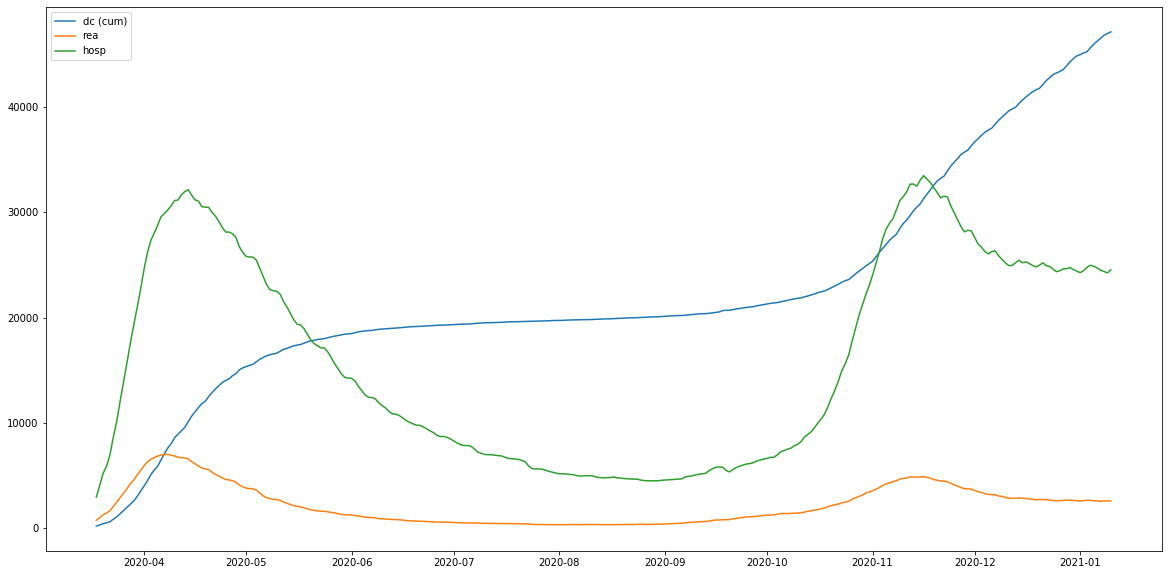

In [5]:
#fig=plt.figure()
plt.plot(days_dt, dc, label='dc (cum)')
plt.plot(days_dt, rea, label='rea')
plt.plot(days_dt, hosp, label='hosp')
plt.legend()

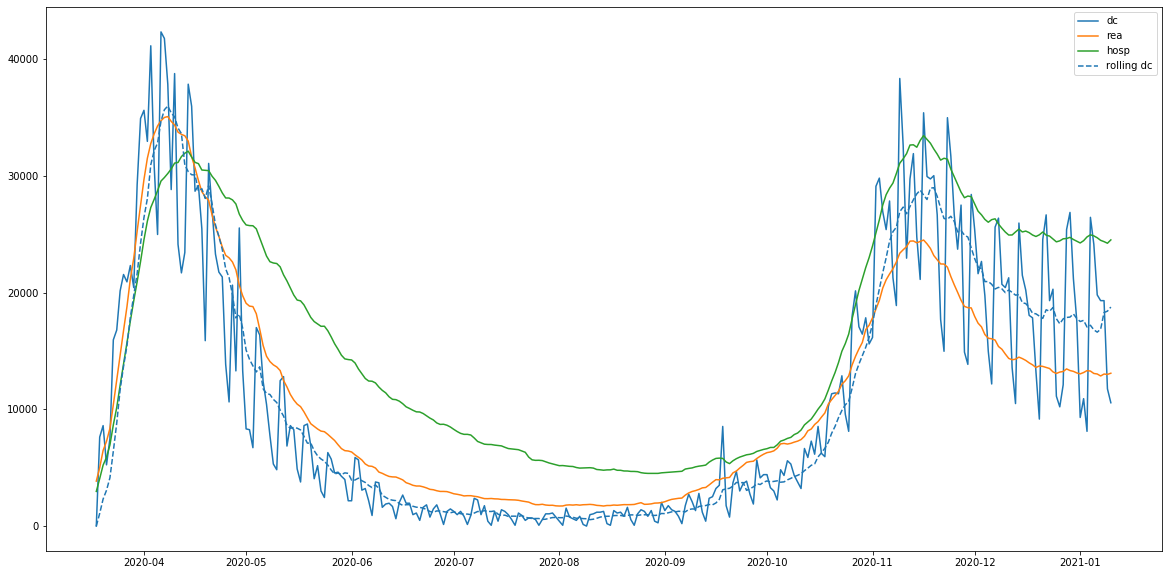

In [6]:
plt.figure()
rolling_dc = np.convolve(np.diff(dc, prepend=dc[0]), np.ones(7))[:-6]
plt.plot(days_dt, np.diff(dc, prepend=dc[0])*70, label='dc')
plt.plot(days_dt, rea*5, label='rea')
plt.plot(days_dt, hosp, label='hosp')
plt.gca().set_prop_cycle(None)
plt.plot(days_dt, rolling_dc*10, '--', label='rolling dc')
plt.legend()

### 2eme vs 1ere

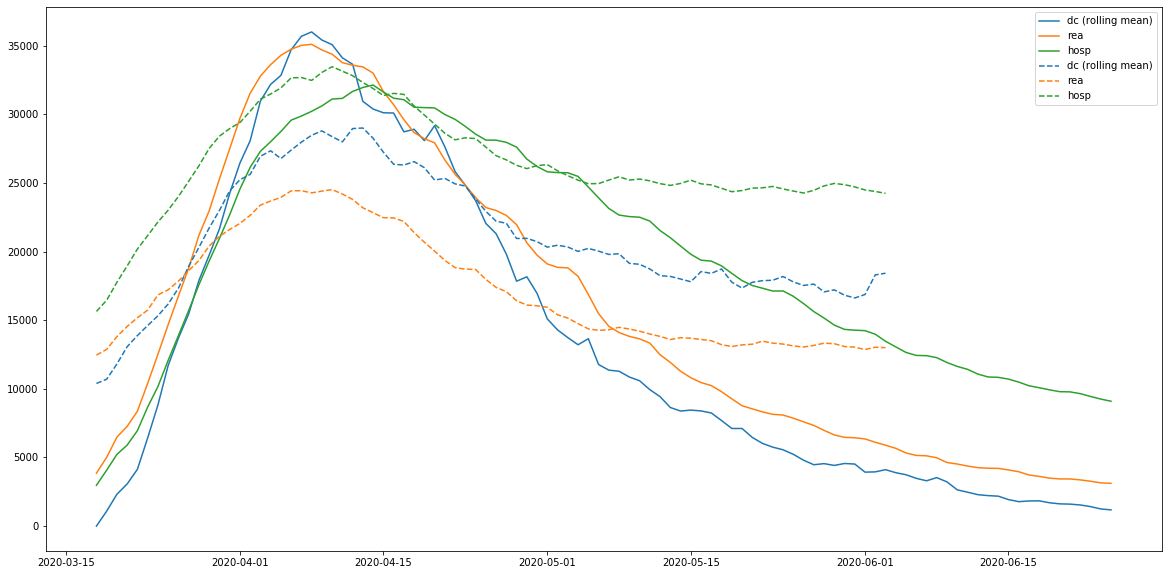

In [7]:
plt.figure()
delta = 220
for debut,fin,style in [[0,100,'-'], [delta,-1,'--']]:
    plt.gca().set_prop_cycle(None)
    delta_dates = days_dt[debut:fin]-dt.timedelta(days=debut)
    plt.plot(delta_dates, rolling_dc[debut:fin]*10, style, label='dc (rolling mean)')
    plt.plot(delta_dates, rea[debut:fin]*5, style, label='rea')
    plt.plot(delta_dates, hosp[debut:fin], style, label='hosp')
plt.legend()

Text(0, 0.5, 'Growth of DC compared to previous week')

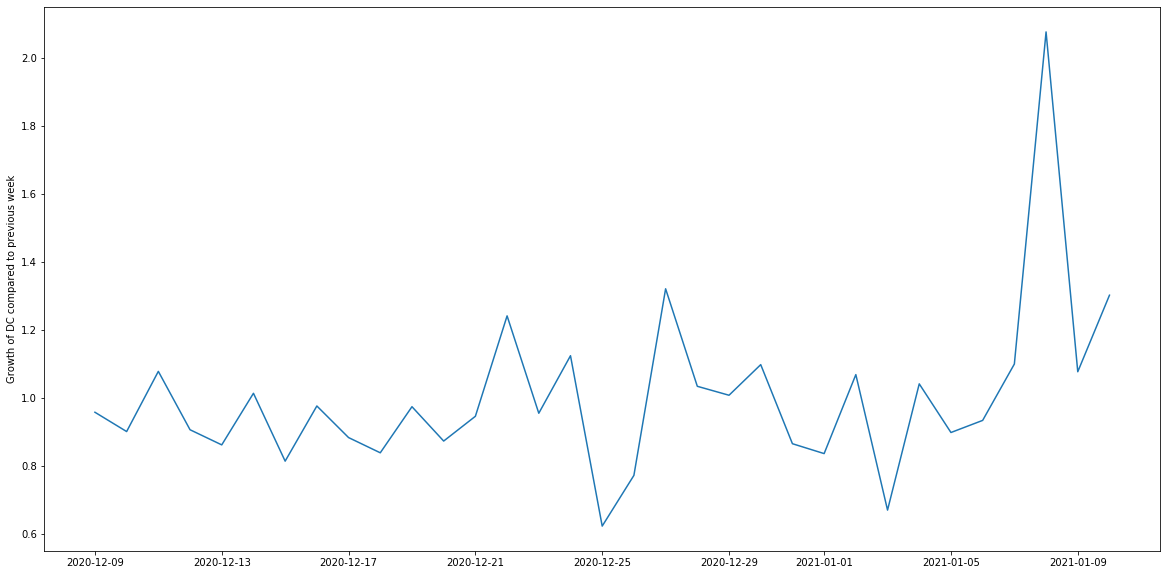

In [8]:
fig = plt.figure()
start = -40
deuxieme = np.diff(dc, prepend=dc[0])[start:]
d = 7 
plt.plot(days_dt[start+d:],deuxieme[d:] / deuxieme[:-d])
plt.ylabel('Growth of DC compared to previous week')

## Moving average

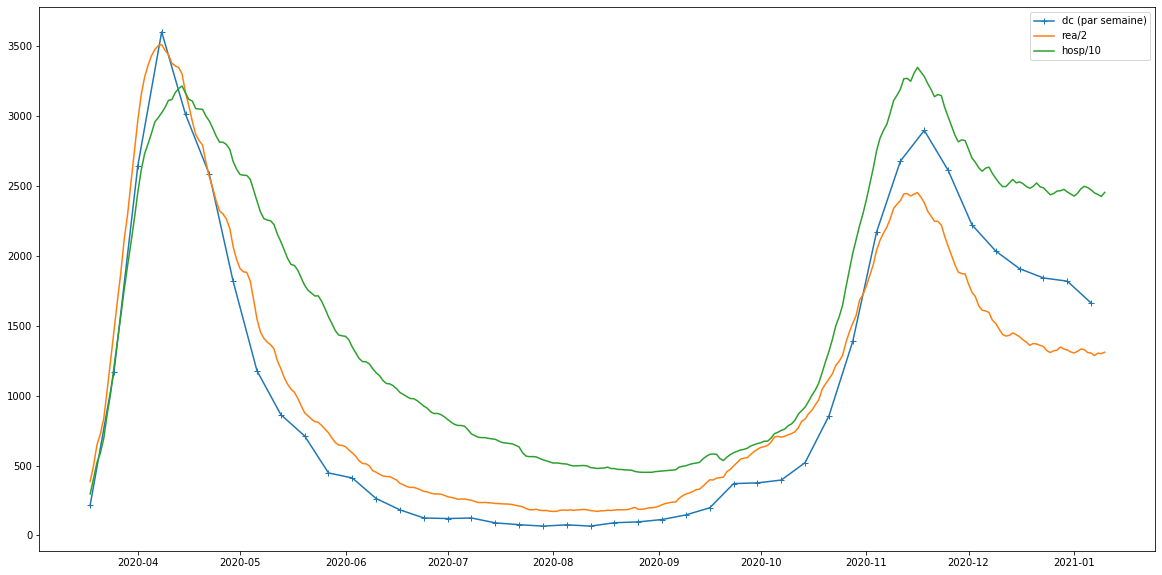

In [9]:
plt.figure()
# 7 days moving average
plt.plot(days_dt[0:len(dc):7], np.diff(dc[0:len(dc):7], prepend=0), '+-', label='dc (par semaine)')
plt.plot(days_dt, rea/2, label='rea/2')
plt.plot(days_dt, hosp/10, label='hosp/10')
plt.legend()

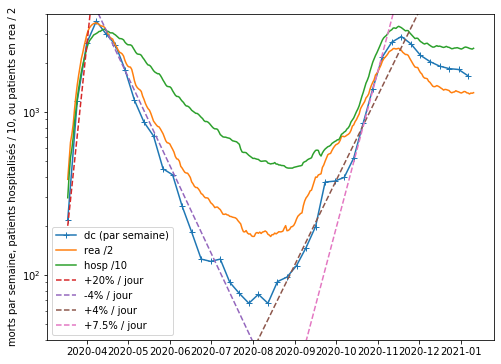

In [10]:
# 7 days moving average
fig = plt.figure()
fig.set_size_inches(8,6)
plt.semilogy(days_dt[0:len(dc):7], np.diff(dc[0:len(dc):7], prepend=0), '+-', label='dc (par semaine)')
plt.plot(days_dt, rea/2, label='rea /2')
plt.plot(days_dt, hosp/10, label='hosp /10')
plt.plot(days_dt, 200*1.20**(np.arange(len(days_dt))),'--', label='+20% / jour')
plt.plot(days_dt, 10000*0.96**(np.arange(len(days_dt))),'--', label='-4% / jour')
plt.plot(days_dt, 1.04**(np.arange(len(days_dt))) / 6,'--', label='+4% / jour')
plt.plot(days_dt, 1.075**(np.arange(len(days_dt))) / 8000,'--', label='+7.5% / jour')
plt.legend()
plt.ylim(40,4000)
plt.ylabel('morts par semaine, patients hospitalisés / 10, ou patients en rea / 2')
plt.savefig('covid_01_11.pdf',bbox_inches='tight')

# Admissions 

In [11]:
df = pd.read_csv('datas/donnees-hospitalieres-nouveaux-covid19-2021-01-10-19h03.csv', sep=';')
days = np.unique(df['jour'].values)
days_dt = np.array([dt.datetime.fromisoformat(day) for day in days])
datas_per_day = []
for day in days:
    datas_per_day.append(df[df['jour']==day])
df

dep        jour  incid_hosp  incid_rea  incid_dc  incid_rad
0       01  2020-03-19           1          0         0          0
1       02  2020-03-19          38          8        10         15
2       03  2020-03-19           2          0         0          6
3       04  2020-03-19           1          0         0          1
4       05  2020-03-19           4          0         0          1
...    ...         ...         ...        ...       ...        ...
30093  971  2021-01-10           0          0         0          0
30094  972  2021-01-10           0          0         0          0
30095  973  2021-01-10           1          0         0          0
30096  974  2021-01-10           0          1         0          1
30097  976  2021-01-10           0          0         0          0

[30098 rows x 6 columns]

In [12]:
def rolling(incid):
    x = np.array([sum(x['incid_{}'.format(incid)].values) for x in datas_per_day])
    y = np.cumsum(x)
    return np.diff(y[0:len(y):7])
date = days_dt[0:len(days_dt):7][1:]   
incid_hosp = rolling('hosp')
incid_rea = rolling('rea')
incid_dc = rolling('dc')

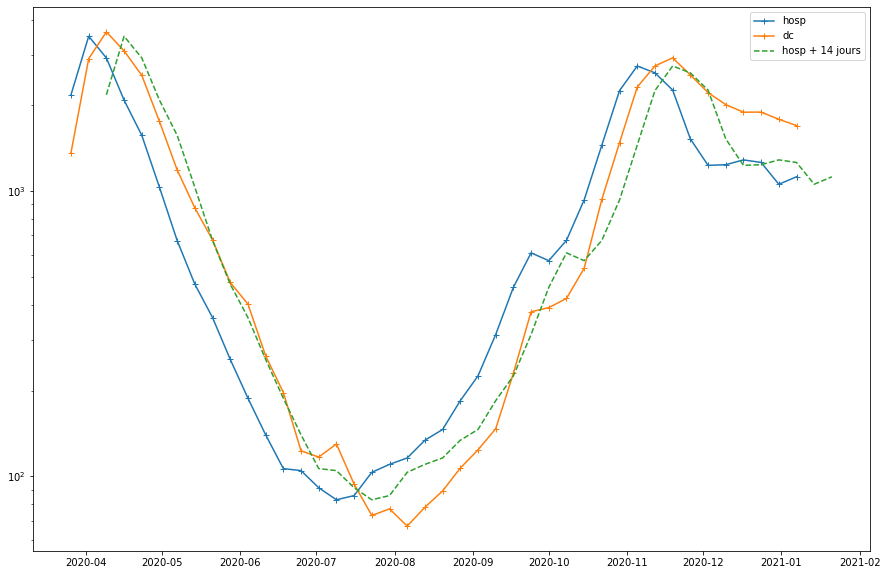

In [13]:
fig = plt.figure()
fig.set_size_inches(15,10)
plt.semilogy(date, incid_hosp/7, '+-',label='hosp')
#plt.plot(date, incid_rea/1.4, '+-', label='rea')
plt.plot(date, incid_dc, '+-', label='dc')
plt.plot(date+dt.timedelta(days=14), incid_hosp/7, '--', label='hosp + 14 jours')
#plt.plot(date[4:6],[1000,1000],'--', label='une semaine')
#plt.plot(date[3:7:2],np.ones(2)*incid_hosp[3]/7,'--', label='trois semaines')
#plt.plot(date[3:7:3],[1500,1500],'--', label='trois semaines')
plt.legend()

# Par dep: comparaison vague 1 vs vague 2 

In [14]:
pop = pd.read_csv('datas/pop_francaise.csv',sep=';')
def dep_code(dep):
    if dep != 20:
        return '{:02d}'.format(dep)
    else:
        return '2A'
def population(dep):
    return int(pop['Total'][pop['Dep']==dep_code(dep)])
def name(dep):
    return list(pop['Unnamed: 1'][pop['Dep']=='{:02d}'.format(dep)])[0]

In [15]:
df = pd.read_csv('datas/donnees-hospitalieres-covid19-2020-11-12-19h00.csv', sep=';')
def morts(vague, dep, sexe=0):
    df_dep = df[(df['dep']==dep_code(dep)) & (df['sexe']==sexe)]
    if vague == 1:
        return int(df_dep[df_dep['jour']=='2020-08-01'].dc)
    elif vague == 2:
        return int(df_dep.dc.values[-1]) - morts(1, dep, sexe)
def taux(vague, dep, sexe=0):
    return morts(vague, dep, sexe) / population(dep)

In [16]:
x = 1000*np.array([[taux(vague, dep) for vague in [1,2]] for dep in range(1,95)])
x1 = 2000*np.array([[taux(vague, dep, 1) for vague in [1,2]] for dep in range(1,95)])
x2 = 2000*np.array([[taux(vague, dep, 2) for vague in [1,2]] for dep in range(1,95)])

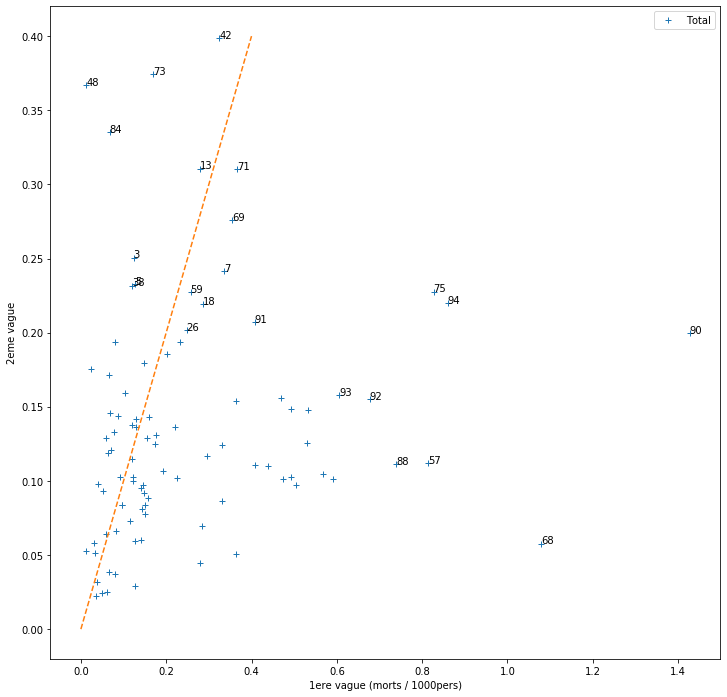

In [17]:
fig = plt.figure()
fig.set_size_inches(12,12)
plt.plot(x[:,0], x[:,1],'+')
#plt.plot(x1[:,0], x1[:,1],'r+')
#plt.plot(x2[:,0], x2[:,1],'g+')
plt.xlabel('1ere vague (morts / 1000pers)')
plt.ylabel('2eme vague')
plt.legend(['Total', 'Homme','Femme'])
for i, y in enumerate(x):
    if y[0] > .6 or y[1] >= 0.2:
        plt.text(y[0],y[1],'{}'.format(i+1))
        #plt.text(x1[i,0],x1[i,1],'{}'.format(i+1))
plt.plot([0,0.4],[0,.4],'--')

## Difference "global" et "homme", compariaon des vagues

Conclusion: on ne voit rien.

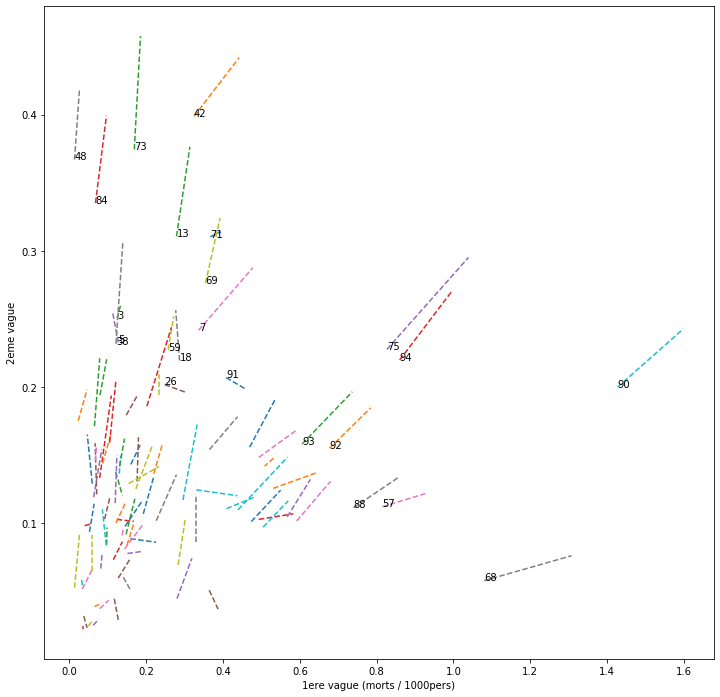

In [18]:
fig = plt.figure()
fig.set_size_inches(12,12)
plt.plot([x[:,0],x1[:,0]],[x[:,1],x1[:,1]],'--')
#plt.plot(x1[:,0], x1[:,1],'r+')
#plt.plot(x2[:,0], x2[:,1],'g+')
plt.xlabel('1ere vague (morts / 1000pers)')
plt.ylabel('2eme vague')
for i, y in enumerate(x):
    if y[0] > .6 or y[1] >= 0.2:
        plt.text(y[0],y[1],'{}'.format(i+1))
        #plt.text(x1[i,0],x1[i,1],'{}'.format(i+1))

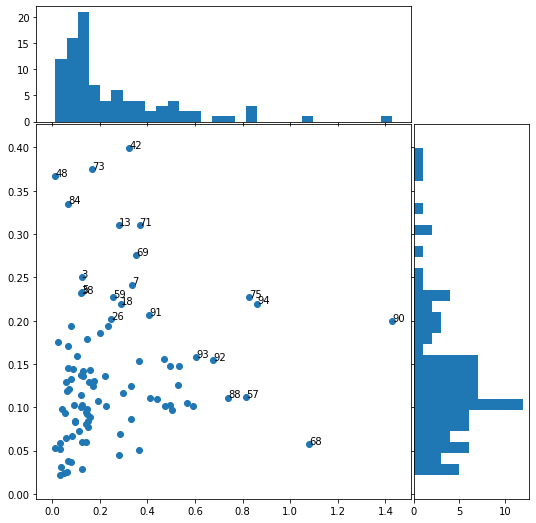

In [19]:
# Code from https://matplotlib.org/3.3.2/gallery/lines_bars_and_markers/scatter_hist.html
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    ax_histx.hist(x, bins=30)
    ax_histy.hist(y, bins=30, orientation='horizontal')
    
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x[:,0], x[:,1], ax, ax_histx, ax_histy)
for i, y in enumerate(x):
    if y[0] > .6 or y[1] >= 0.2:
        ax.text(y[0],y[1],'{}'.format(i+1))


## Comparaison homme-femme

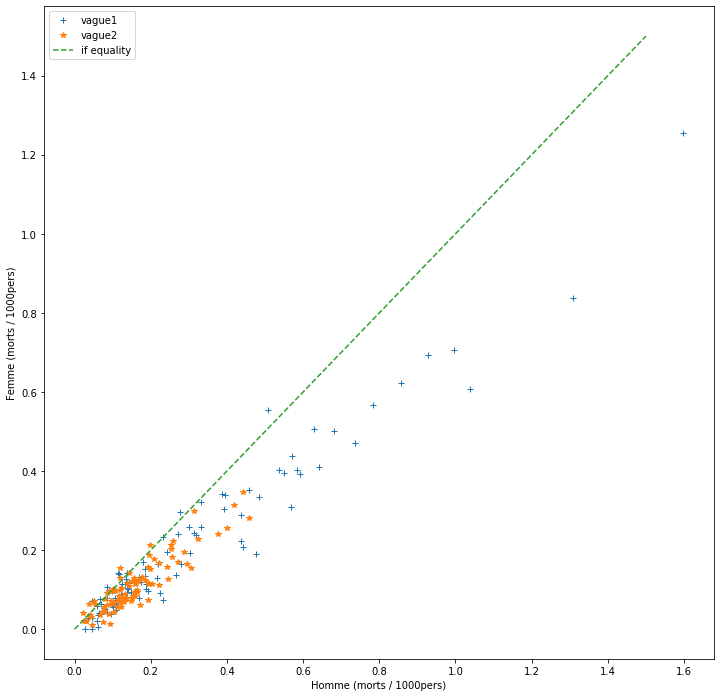

In [21]:
fig = plt.figure()
fig.set_size_inches(12,12)
plt.plot(x1[:,0],x2[:,0],'+', label='vague1')
plt.plot(x1[:,1],x2[:,1],'*', label='vague2')
plt.plot([0,1.5],[0,1.5],'--', label='if equality')
plt.xlabel('Homme (morts / 1000pers)')
plt.ylabel('Femme (morts / 1000pers)')
plt.legend()


# Donnés des tests
Data de https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/

In [23]:
df = pd.read_csv('datas/sp-pos-quot-dep-2021-01-10-19h20.csv', sep=';')
#days = np.unique(df['jour'].values)
days_dt = np.array([dt.datetime.fromisoformat(day) for day in days])
datas_per_day = []
tests_per_day = []
for day in days:
    data = df[np.logical_and(df['jour']==day, df['cl_age90']==0)]
    datas_per_day.append(data)
    tests_per_day.append([np.sum(data['P']), np.sum(data['T'])])
tests = np.array(tests_per_day)

In [24]:
test_P, test_N = tests[:,0], tests[:,1]

In [25]:
def rolling(data):
    cs = np.cumsum(data)
    return (cs[7:] - cs[0:-7])/7
test_P_r = rolling(test_P)
test_N_r = rolling(test_N)

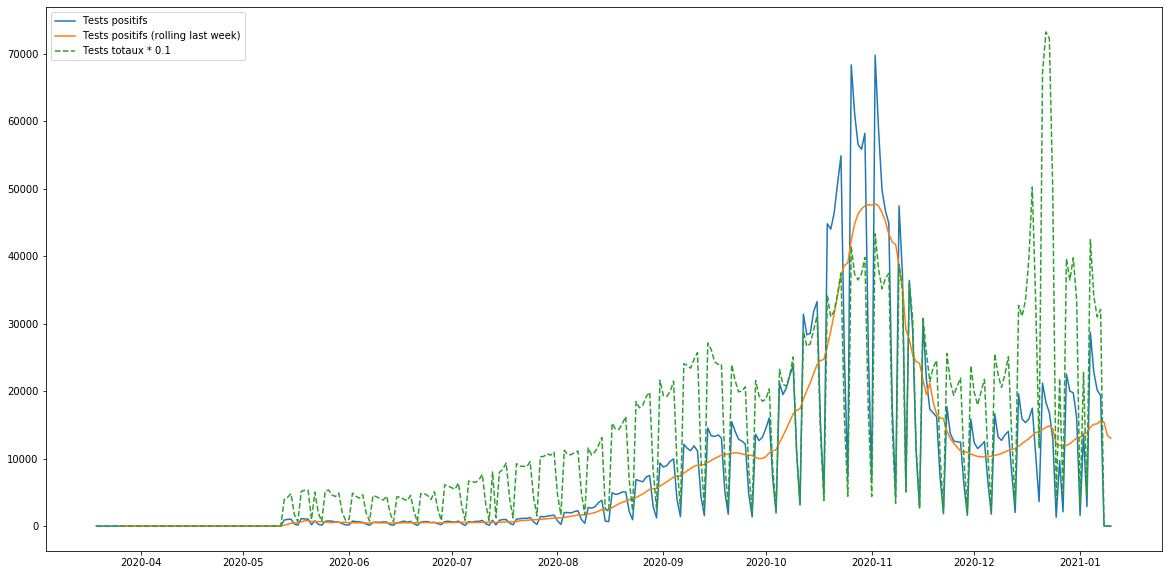

In [26]:
plt.plot(days_dt, test_P, label='Tests positifs')
plt.plot(days_dt[7:], test_P_r, label='Tests positifs (rolling last week)')
plt.plot(days_dt, test_N*0.1, '--', label='Tests totaux * 0.1')
plt.legend()